In [1]:
import warnings
warnings.filterwarnings('ignore')

### Run in collab
<a href="https://colab.research.google.com/github/racousin/rl_introduction/blob/master/notebooks/6_RL_framework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# uncomment lines
#!pip install stable_baselines[mpi]==2.9.0
#!pip install tensorflow==1.14.0
#!pip install box2d-py
#!pip install gym[Box_2D]
#!apt update
#!apt install xvfb
#!pip install pyvirtualdisplay

In [3]:
#restart runtime, then uncomment lines
#import warnings
#warnings.filterwarnings('ignore')
#import pyvirtualdisplay
#d = pyvirtualdisplay.Display()
#d.start() # Start Xvfb and set "DISPLAY" environment properly.

In [5]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gym
import numpy as np
import os

# baselines framework
see code:
- https://github.com/DLR-RM/stable-baselines3

And doc:
- https://stable-baselines3.readthedocs.io/en/master/index.html

Pre-trained agent:
- https://github.com/DLR-RM/rl-baselines3-zoo

### Train, Save, Load (Example DQN): 

In [7]:
import gym

from stable_baselines3 import DQN
from stable_baselines3.common.evaluation import evaluate_policy


# Create environment
env = gym.make('LunarLander-v2')

# Instantiate the agent
model = DQN('MlpPolicy', env, learning_rate=1e-3)#, prioritized_replay=True, verbose=1)
# Train the agent
model.learn(total_timesteps=10000)
# Save the agent
model.save("dqn_lunar")
del model  # delete trained model to demonstrate loading


In [8]:
# Load the trained agent
model = DQN.load("dqn_lunar")

# Evaluate the agent
mean_reward, n_steps = evaluate_policy(model, env, n_eval_episodes=10)

### render locally

In [10]:
# Enjoy trained agent
obs = env.reset()
for i in range(1000):
    action, _states = model.predict(obs) 
    #action = env.action_space.sample()
    obs, rewards, done, info = env.step(action)
    env.render()
    if done:
        env.reset()
env.close()

### render with collab

In [ ]:
# Enjoy trained agent
import base64
import io
import gym
from gym.wrappers import Monitor
from IPython import display
from pyvirtualdisplay import Display

d = Display()
d.start()

env = Monitor(gym.make('LunarLander-v2'),'./monitor')

obs = env.reset()

for _ in range(1000):
    action, _states = model.predict(obs)
    #action = env.action_space.sample()
    obs, rewards, done, info = env.step(action)

    if done:
        env.reset()

for f in env.videos:
    video = io.open(f[0], 'r+b').read()
    encoded = base64.b64encode(video)

    display.display(display.HTML(data="""
        <video alt="test" controls>
        <source src="data:video/mp4;base64,{0}" type="video/mp4" />
        </video>
        """.format(encoded.decode('ascii'))))

In [11]:
# Create environment
env = gym.make('LunarLander-v2')

### Hyper parameters:

In [14]:
from stable_baselines3 import DQN, A2C
import torch as th

#### The policy:

You can use available policies 'MlpPolicy' (fully connected), 'CnnPolicy' (convolutional) and configure them. For example:
- 3 layers of 32, 16, 8 neurons for dqn

In [17]:
policy_kwargs = dict(activation_fn=th.nn.ReLU, net_arch=[32, 16, 8])
model = DQN('MlpPolicy', env, policy_kwargs=policy_kwargs)
model.learn(total_timesteps=500)

- 1 share layer of 64 neurons
- 2 specifics layers od 32, 16 neurons for policy model
- 3 specifics layers of 64, 16, 16 neurons for value function model

In [18]:
policy_kwargs = dict(activation_fn=th.nn.ReLU, net_arch=[64, dict(pi=[32, 16],
                                                          vf=[64, 16, 16])])
model = A2C('MlpPolicy', env, policy_kwargs=policy_kwargs)
model.learn(total_timesteps=500)

#### Specific parameters of algorithms

For example for DQN:
- buffer_size – (int) size of the replay buffer
- batch_size – (int) size of a batched sampled from replay buffer for training
- double_q – (bool) Whether to enable Double-Q learning or not.
- prioritized_replay – (bool) if True prioritized replay buffer will be used.
- learning_rate – (float) learning rate



In [20]:
model = DQN('MlpPolicy', env,
            learning_rate=0.0005,
            buffer_size=50000,
            batch_size=32)
model.learn(total_timesteps=500)

For example for A2C:
- n_steps – (int) The number of steps to run for each environment per update (i.e. batch size is n_steps * n_env where n_env is number of environment copies running in parallel)
- max_grad_norm – (float) The maximum value for the gradient clipping
- learning_rate – (float) The learning rate

In [21]:
model = A2C('MlpPolicy', env,
            learning_rate=0.0007,
            n_steps=5,
            max_grad_norm=0.5)
model.learn(total_timesteps=500)

### monitoring 

In [33]:
from stable_baselines3.common.monitor import Monitor
from stable_baselines3 import DDPG, DQN
import seaborn as sns
sns.set_style("darkgrid")

In [34]:

#from stable_baselines3.deepq.policies import MlpPolicy
from stable_baselines3 import PPO, DQN
# Create log dir
time_steps = 1000
log_dir = "tmp/test"
os.makedirs(log_dir, exist_ok=True)

env = gym.make('CartPole-v0')
env = Monitor(env, log_dir, allow_early_resets=True)

model = DQN('MlpPolicy', env, verbose=0)
time_steps = 5000
model.learn(total_timesteps=time_steps)

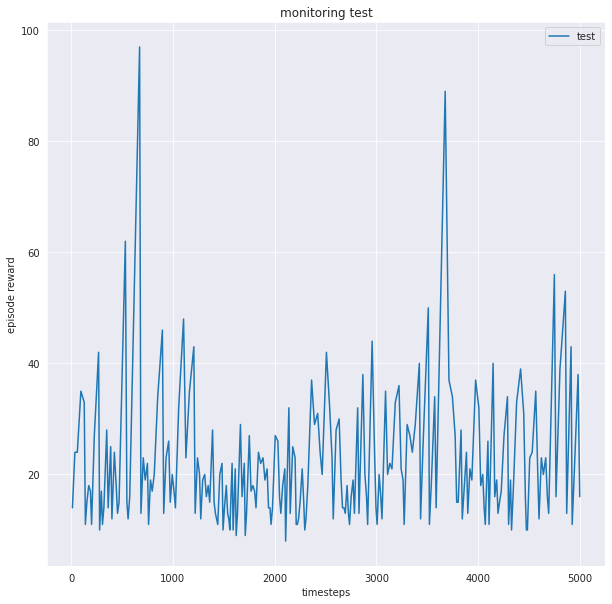

In [35]:
fig,ax = plt.subplots(figsize=(10,10))
res = pd.read_csv(log_dir+'/monitor.csv', skiprows=1)
ax.plot(res['l'].cumsum(), res['r'], label = 'test')
ax.set_xlabel('timesteps')
ax.set_ylabel('episode reward')
ax.set_title('monitoring test')
ax.legend()

### Benchmark

In [36]:
env_names = ['MountainCar-v0','CartPole-v1','LunarLander-v2']
algs = [A2C,DQN]
alg_names = ['a2c','dqn']
layers = [[32],[64,32],[64,32,16]]

In [37]:
time_steps = 100000

In [39]:
for env_name in env_names:
    for i,alg in enumerate(algs):
        print(alg_names[i])
        for l,layer in enumerate(layers):
            
            log_dir= output_dir='tmp/'+alg_names[i]+'_'+env_name + '_' + str(len(layer))
            os.makedirs(log_dir, exist_ok=True) 
            
            env = gym.make(env_name)
            env = Monitor(env, log_dir, allow_early_resets=True)
            
            if alg_names[i] == 'dqn':
                policy_kwargs = dict(activation_fn=th.nn.ReLU, net_arch=layer)
            else:
                policy_kwargs = dict(activation_fn=th.nn.ReLU, net_arch=layer)
            
            model = alg('MlpPolicy', env, verbose=0, policy_kwargs=policy_kwargs)

            model.learn(total_timesteps=time_steps)# , callback=callback)

a2c
dqn
a2c
dqn
a2c
dqn


a2c
dqn
a2c
dqn
a2c
dqn


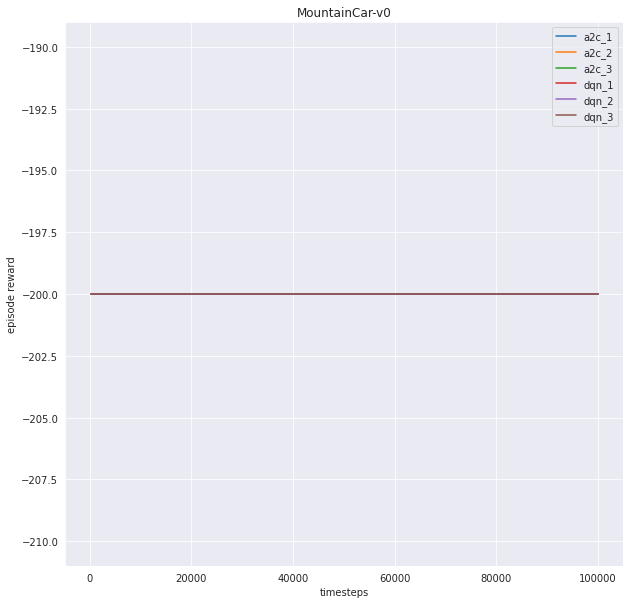

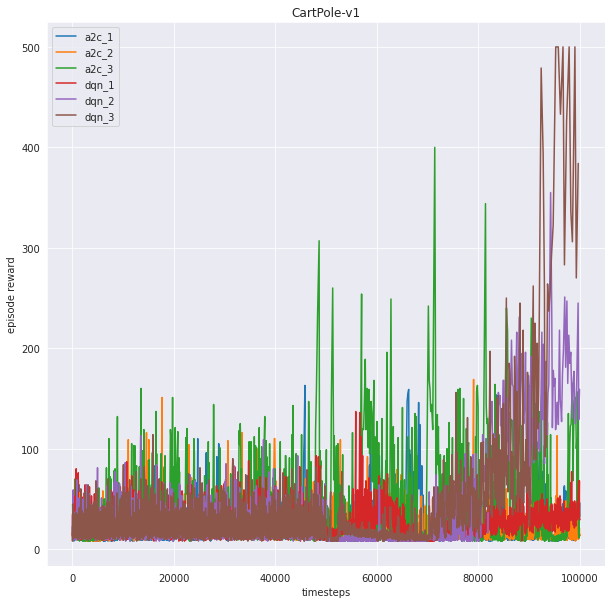

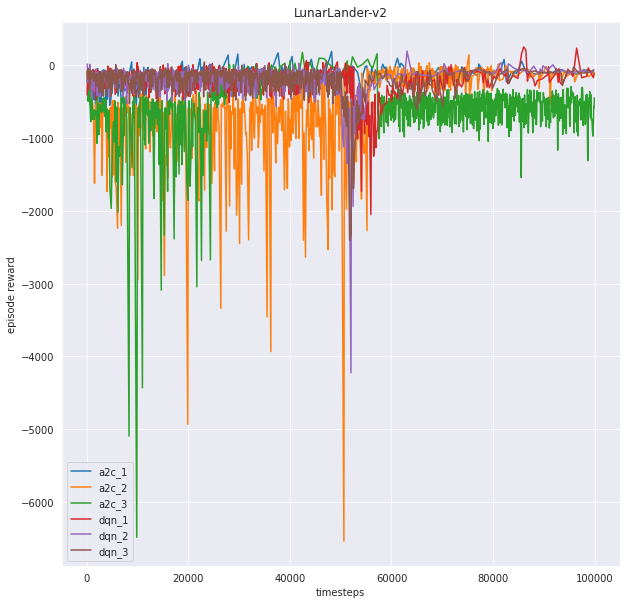

In [41]:
glob_res = {}
for env_name in env_names:
    fig,ax = plt.subplots(figsize=(10,10))
    glob_res['env_name'] = {}
    for i,alg in enumerate(algs):
        glob_res['env_name'][alg_names[i]] = {}
        print(alg_names[i])
        for l,layer in enumerate(layers):

            log_dir= output_dir='tmp/'+alg_names[i]+'_'+env_name + '_' + str(len(layer))
            res = pd.read_csv(log_dir+'/monitor.csv', skiprows=1)
            ax.plot(res['l'].cumsum(), res['r'], label = alg_names[i]+ '_' + str(len(layer)))
            
            glob_res['env_name'][alg_names[i]][str(len(layer))] = res
    ax.set_xlabel('timesteps')
    ax.set_ylabel('episode reward')
    ax.set_title(env_name)
    ax.legend()

### More complete benchmark for doing better!

DQN parameter
https://github.com/openai/baselines-results/blob/master/dqn_results.ipynb

atari baselines scores https://github.com/araffin/rl-baselines-zoo/blob/master/benchmark.md

atari spinningup scores https://spinningup.openai.com/en/latest/spinningup/bench.html

compute other metrics https://github.com/deepmind/bsuite

### Example of train with atari

In [ ]:
from stable_baselines3.common.cmd_util import make_atari_env
from stable_baselines3.common.vec_env import VecFrameStack
from stable_baselines3 import A2C

# There already exists an environment generator
# that will make and wrap atari environments correctly.
# Here we are also multiprocessing training (num_env=4 => 4 processes)
env = make_atari_env('PongNoFrameskip-v4', n_envs=4, seed=0)
# Frame-stacking with 4 frames
env = VecFrameStack(env, n_stack=8)

model = A2C('CnnPolicy', env, verbose=1)
model.learn(total_timesteps=250000)

Using cpu device
Wrapping the env in a VecTransposeImage.
------------------------------------
| time/                 |          |
|    fps                | 343      |
|    iterations         | 100      |
|    time_elapsed       | 5        |
|    total_timesteps    | 2000     |
| train/                |          |
|    entropy_loss       | -1.77    |
|    explained_variance | -0.0162  |
|    learning_rate      | 0.0007   |
|    n_updates          | 99       |
|    policy_loss        | 0.0248   |
|    value_loss         | 0.00022  |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 3.59e+03 |
|    ep_rew_mean        | -20.2    |
| time/                 |          |
|    fps                | 335      |
|    iterations         | 200      |
|    time_elapsed       | 11       |
|    total_timesteps    | 4000     |
| train/                |          |
|    entropy_loss       | -1.71    |
|    explained_va

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 3.75e+03 |
|    ep_rew_mean        | -20.1    |
| time/                 |          |
|    fps                | 343      |
|    iterations         | 1500     |
|    time_elapsed       | 87       |
|    total_timesteps    | 30000    |
| train/                |          |
|    entropy_loss       | -1.63    |
|    explained_variance | 0.81     |
|    learning_rate      | 0.0007   |
|    n_updates          | 1499     |
|    policy_loss        | 0.0735   |
|    value_loss         | 0.0024   |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 3.77e+03 |
|    ep_rew_mean        | -20.2    |
| time/                 |          |
|    fps                | 344      |
|    iterations         | 1600     |
|    time_elapsed       | 92       |
|    total_timesteps    | 32000    |
| train/                |          |
|

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 3.71e+03 |
|    ep_rew_mean        | -20.4    |
| time/                 |          |
|    fps                | 347      |
|    iterations         | 2900     |
|    time_elapsed       | 167      |
|    total_timesteps    | 58000    |
| train/                |          |
|    entropy_loss       | -1.76    |
|    explained_variance | 0.0418   |
|    learning_rate      | 0.0007   |
|    n_updates          | 2899     |
|    policy_loss        | 0.0366   |
|    value_loss         | 0.000733 |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 3.72e+03 |
|    ep_rew_mean        | -20.3    |
| time/                 |          |
|    fps                | 347      |
|    iterations         | 3000     |
|    time_elapsed       | 172      |
|    total_timesteps    | 60000    |
| train/                |          |
|